In [ ]:
import numpy as np 
import pandas as pd 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' ## hide tf warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

##Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
from keras.preprocessing.image import ImageDataGenerator
# Define train and test data path
train_dir = '/content/drive/MyDrive/seg_train'
val_dir = '/content/drive/MyDrive/val/val'
test_dir='/content/drive/MyDrive/test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print('Training images:')
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                              image_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical")

print('Testing images:')
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                              image_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical")

Training images:
Found 14034 files belonging to 6 classes.
Testing images:
Found 3000 files belonging to 6 classes.


In [ ]:
# Checkpoint path
CheckpointPath="EfficientNetB0.h5"

CheckpointCallback= tf.keras.callbacks.ModelCheckpoint(
                            filepath=CheckpointPath,
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=False,
                            monitor='val_accuracy',
                            period=1
)

### Learning rate reduction callback
Reduce learning rate when a metric has stopped improving

In [ ]:
Learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                             mode='auto',
                                            cooldown=1 )

 ### Early stopping callback
 
 Stop training when a monitored metric has stopped improving.

In [ ]:
Early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  min_delta=0.001,
                                                  patience = 5,
                                                  verbose = 1,
                                                  restore_best_weights=True)

In [ ]:
# Create base model (load the pre-trained model)
base_model_EfficientNetB0 = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (pre-trained patterns aren't update during training)
base_model_EfficientNetB0.trainable = False

# Create inputs 
inputs = tf.keras.layers.Input(shape=(150,150,3), name="input_layer")

# Pass the inputs to the base model
x = base_model_EfficientNetB0(inputs)

# Average pooling the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create output activation layer
outputs = tf.keras.layers.Dense(6,activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

# Fit the model and save its history
history_1 = model_1.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data),
                       callbacks=[
                                  CheckpointCallback,
                                  Early_stopping,
                                  Learning_rate_reduction]) 

Epoch 1/5
439/439 [==============================] - ETA: 0s - loss: 1.0483 - accuracy: 0.6722
Epoch 1: val_accuracy improved from -inf to 0.85967, saving model to EfficientNetB0.h5
439/439 [==============================] - 489s 1s/step - loss: 1.0483 - accuracy: 0.6722 - val_loss: 0.5614 - val_accuracy: 0.8597 - lr: 1.0000e-04
Epoch 2/5
439/439 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8791
Epoch 2: val_accuracy improved from 0.85967 to 0.88900, saving model to EfficientNetB0.h5
439/439 [==============================] - 442s 1s/step - loss: 0.4512 - accuracy: 0.8791 - val_loss: 0.3782 - val_accuracy: 0.8890 - lr: 1.0000e-04
Epoch 3/5
439/439 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8967
Epoch 3: val_accuracy improved from 0.88900 to 0.89633, saving model to EfficientNetB0.h5
439/439 [==============================] - 433s 986ms/step - loss: 0.3411 - accuracy: 0.8967 - val_loss: 0.3198 - val_accuracy: 0.8963 - lr: 1.0000e-0

### Loss curves

In [ ]:
#Create a function to plot loss curves
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    plt.plot(history.history["loss"], label="training_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(history.history["accuracy"], label="training_accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

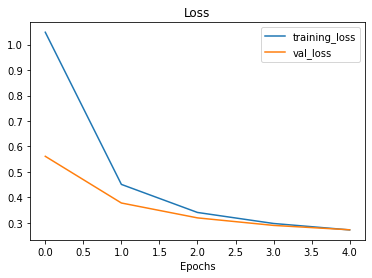

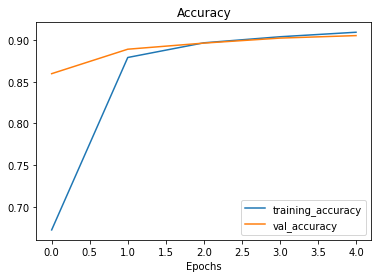

In [ ]:
plot_loss_curves(history_1)

<h1 id="ergffseqs" style="color:white;background:#0087B6;padding:8px;border-radius:8px"> Fine tuning </h1>

I will unfreeze the last 15 layers of the base model and continue training for 5 more epochs, you can also unfreeze less or more layers and let me know if you achieved better score.

## EfficientNetB0 Fine tuning

In [ ]:
# Unfreeze all layers of the base model
base_model_EfficientNetB0.trainable= True

# Freeze all layers except the last 15 layer
for layer in base_model_EfficientNetB0.layers[:-15]:
    layer.trainable=False

# Recompile
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])


### Fit the model 

In [ ]:
#Fine tune for another 5 epochs
initial_epochs= 5
fine_tune_epochs=initial_epochs + 5

history_2 = model_1.fit(train_data,
                                       epochs=fine_tune_epochs,
                                       validation_data=val_data,
                                       validation_steps=len(val_data),
                                       initial_epoch=history_1.epoch[-1],
                                       callbacks=[
                                  CheckpointCallback,
                                  Early_stopping, 
                                  Learning_rate_reduction])

Epoch 5/10
439/439 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.9005
Epoch 5: val_accuracy improved from 0.90533 to 0.91633, saving model to EfficientNetB0.h5
439/439 [==============================] - 498s 1s/step - loss: 0.2936 - accuracy: 0.9005 - val_loss: 0.2180 - val_accuracy: 0.9163 - lr: 1.0000e-04
Epoch 6/10
439/439 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9254
Epoch 6: val_accuracy improved from 0.91633 to 0.91867, saving model to EfficientNetB0.h5
439/439 [==============================] - 488s 1s/step - loss: 0.2087 - accuracy: 0.9254 - val_loss: 0.2050 - val_accuracy: 0.9187 - lr: 1.0000e-04
Epoch 7/10
439/439 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9364
Epoch 7: val_accuracy improved from 0.91867 to 0.92467, saving model to EfficientNetB0.h5
439/439 [==============================] - 479s 1s/step - loss: 0.1799 - accuracy: 0.9364 - val_loss: 0.1975 - val_accuracy: 0.9247 - lr: 1.0000

#### The model achieved 93% accuracy after fine tuning

### Fine tuning results

In [ ]:
#compare histories
def compare_histories(history,new_history,initial_epochs):
    loss=history.history["loss"]
    val_loss=history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs=range(len(history.history["loss"])+len(new_history.history["loss"]))
    
    total_acc= accuracy+ new_history.history["accuracy"]
    total_loss=loss+ new_history.history["loss"]
    
    total_val_acc= val_accuracy + new_history.history["val_accuracy"]
    total_val_loss=val_loss+ new_history.history["val_loss"]

    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc ,label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation accuracy")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training_loss")
    plt.plot(total_val_loss, label="Val_loss")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation Loss")
    plt.legend()
    

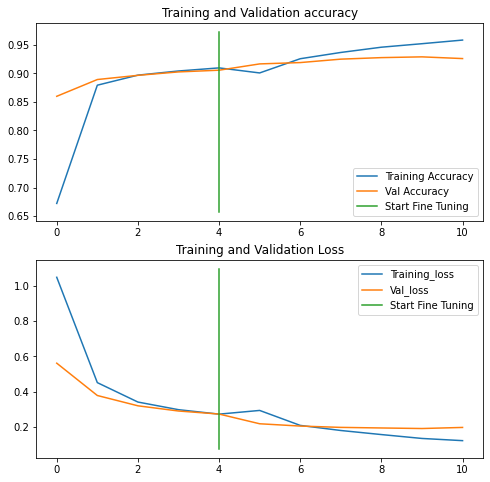

In [ ]:
compare_histories(history_1,history_2,5)

In [ ]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(test_dir)
len(images_paths)
file_array = []

for file in images_paths:
    files = cv2.imread(file)/255.0 
    file_array.append(files)
file_array = np.array(file_array,dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
from tensorflow.keras.utils import load_img

X = []
for i in range(0, 3000):
  image = load_img(f'/content/drive/MyDrive/test/test/test/{i}.jpg')
  X.append(image) 
for j in range(len(X)):
  X[j] = np.array(X[j])
  X[j] = cv2.resize(X[j] , (150,150))
X = np.array(X)
X.shape

(3000, 150, 150, 3)

In [ ]:
predictions = model_1.predict(X)

In [ ]:
label = np.argmax(predictions, axis=1)

In [ ]:
id=np.arange(0,3000)
data={"id":id, "label":label}
result=pd.DataFrame(data)
print(result)
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([id, label]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)


        id  label
0        0      5
1        1      4
2        2      0
3        3      2
4        4      4
...    ...    ...
2995  2995      4
2996  2996      4
2997  2997      0
2998  2998      1
2999  2999      1

[3000 rows x 2 columns]


In [ ]:
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([id, label]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)
